<a href="https://colab.research.google.com/github/fabriciocovalesci/tcc_predict_crypto/blob/main/model_predict/predict_crypto/bitcoin/Bitcoin_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Modelo preditivo Bitcoin

- Instalar biblioteca **yfinance**

In [ ]:
!pip install yfinance --upgrade --no-cache-dir 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 8.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


- Importar bibliotecas de manipulação de dados

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

- Importar bibliotecas realizar as predições

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
import joblib

- Importar bibliotecas para plotar gráficos

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

- Importar bibliotecas internas do python

In [ ]:
from functools import reduce
from datetime import datetime
from math import sqrt

- Definir datas para capturar os dados

In [ ]:
date_today = datetime.strftime(datetime.today(), '%Y-%m-%d')
date_init = "2014-01-01"

- Criar funções auxiliares 

In [ ]:
list_tickers = ["BTC-USD"]

def download_tickers(ticker):
  try:
    asset = yf.download(ticker, start=date_init, end=date_today, interval='1d')
    return asset.Close
  except Exception as err:
    print(f"ERROR: {err}")

  
def create_data_frame(asset_close, ticker):
  return pd.DataFrame(asset_close).rename(columns = {'Close': ticker})


def mean_absolute_percentage_error(y_true, y_pred):
	"""Take in true and predicted values and calculate the MAPE score"""
	y_true, y_pred = np.array(y_true), np.array(y_pred)
	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

- Download dos dados

In [ ]:
df_btc = yf.download("BTC-USD", date_init, date_today)
df_btc = df_btc.reset_index()

[*********************100%***********************]  1 of 1 completed


- Renomendo colunas

In [ ]:
df_btc.rename({'Date': 'timestamp', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Adj Close': 'close', 'Volume': 'volume' }, axis=1, inplace=True)


In [ ]:
df_btc.tail(1)

,timestamp,open,high,low,Close,close,volume
2964,2022-10-29,20595.103516,20988.394531,20566.484375,20818.476562,20818.476562,40369840645


In [ ]:
df_btc.dtypes

timestamp    datetime64[ns]
open                float64
high                float64
low                 float64
Close               float64
close               float64
volume                int64
dtype: object

- Converter data

In [ ]:
df_btc['timestamp'] = pd.to_datetime(df_btc['timestamp'], format="%Y-%m-%d")

- Criar médias móveis de 7 dias e 21 dias

In [ ]:
df_btc['mm7d'] = df_btc['close'].rolling(7).mean()
df_btc['mm21d'] = df_btc['close'].rolling(21).mean()

df_btc.tail(1)

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
2964,2022-10-29,20595.103516,20988.394531,20566.484375,20818.476562,20818.476562,40369840645,20211.220424,19554.224423


- Função de agrupamento dos dados

In [ ]:
def group_data(type_group):
  new_df = df_btc.groupby(pd.Grouper(key="timestamp", freq=type_group)).sum()
  new_df.reset_index(inplace=True)
  return new_df

- Função para plotar grafico conforme o Agrupamento dos Dados
- Tipo de agrupamento:
- Por Meses (M) ou por Semanas (W)
- Por Ano (year)
- Tipo de grafico: 'bar',  'line',  'hist',  'barh'

In [ ]:
def create_plot_custom(filter_Mounth_or_Week, year, type_plot):
  """ 
    Cria um grafico filtrando por Ano, Meses ou Semanas

    filter_Mounth_or_Week: 'M' ou 'W'
    type_plot: 'line', 'bar', 'hist', 'barh'
  
  """
  if year >= 2014 and year <= 2022 and filter_Mounth_or_Week in ("M", "W"):
    filtro_label = None
    df_filter = group_data(filter_Mounth_or_Week)
    include = df_filter[df_filter['timestamp'].dt.year == year]
    meses = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]
    if len(include.index) == 12:
      include.index = meses[:len(include.index)]
      filtro_label = "Meses"
    elif len(include.index) > 50:
      include.index = [i for i in range(0, len(include.index))]
      filtro_label = "Semanas"
    include.plot(y="close", kind=type_plot, figsize=(14, 8),rot=30, title=f'Distruibuição por {filtro_label} - ano {year}', ylabel='Preço US$', xlabel=filtro_label, color="blue")

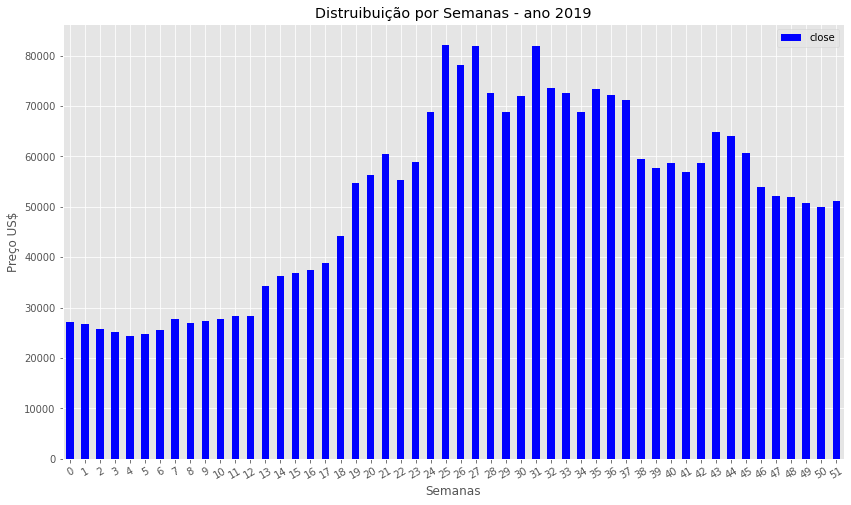

In [ ]:
create_plot_custom("W", 2019, "bar")

- Empurrando para frente os valores da criptomoeda

In [ ]:
df_btc['timestamp'] = df_btc['timestamp'].shift(-1)
df_btc.tail()

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
2960,2022-10-26,19344.964844,20348.412109,19261.447266,20095.857422,20095.857422,47761524910,19368.910156,19392.770740
2961,2022-10-27,20092.236328,20938.134766,20076.117188,20770.441406,20770.441406,58895950537,19601.896763,19421.805246
2962,2022-10-28,20772.802734,20854.044922,20255.373047,20285.835938,20285.835938,49625110402,19777.910435,19437.538225
2963,2022-10-29,20287.957031,20724.980469,20086.068359,20595.351562,20595.351562,43994715910,19981.179408,19487.466890
2964,NaT,20595.103516,20988.394531,20566.484375,20818.476562,20818.476562,40369840645,20211.220424,19554.224423


- Remover os dados nulos

In [ ]:
df_btc.dropna(inplace=True)
df_btc

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
20,2014-10-08,330.584015,339.247009,320.481995,336.187012,336.187012,49199900,347.691572,387.352142
21,2014-10-09,336.115997,354.364014,327.187988,352.940002,352.940002,54736300,343.309431,382.380999
22,2014-10-10,352.747986,382.726013,347.687012,365.026001,365.026001,83641104,341.874289,379.551761
23,2014-10-11,364.687012,375.066986,352.963013,361.562012,361.562012,43665700,342.167149,377.969190
24,2014-10-12,361.362000,367.191010,355.950989,362.299011,362.299011,13345200,346.943294,375.749906
...,...,...,...,...,...,...,...,...,...
2959,2022-10-25,19567.769531,19589.125000,19206.324219,19345.572266,19345.572266,30202235805,19260.132812,19404.246280
2960,2022-10-26,19344.964844,20348.412109,19261.447266,20095.857422,20095.857422,47761524910,19368.910156,19392.770740
2961,2022-10-27,20092.236328,20938.134766,20076.117188,20770.441406,20770.441406,58895950537,19601.896763,19421.805246
2962,2022-10-28,20772.802734,20854.044922,20255.373047,20285.835938,20285.835938,49625110402,19777.910435,19437.538225


- Testar se o DataFrame possui dados nulos

In [ ]:
assert df_btc.isnull().sum().sum() == 0

- Separar os dados em Treino, Teste e Validação. 

In [ ]:
qtd_linhas = len(df_btc)

qtd_linhas_treino= round(.70 * qtd_linhas)
qtd_linhas_teste= qtd_linhas - qtd_linhas_treino  
qtd_linhas_validacao = qtd_linhas -1

info = (
    f"linhas treino= 0:{qtd_linhas_treino}"
    f" linhas teste= {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste -1}"
    f" linhas validação= {qtd_linhas_validacao}"
)

info

'linhas treino= 0:2061 linhas teste= 2061:2943 linhas validação= 2943'

- Separar a **labels** que será o target a ser encontrado pelo modelo preditivo
- Separar as **features** que serão utilizadas para prever o valor final

In [ ]:
features = df_btc.drop(['timestamp', 'close'], 1)
labels = df_btc['close']

- Escolhendo as melhores features com Kbest

In [ ]:
features_list = ('timestamp', 'open', 'high', 'low', 'Close', 'close', 'volume', 'mm7d', 'mm21d')

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()

print ("\nMelhores features:")
print (k_best_features_final)


Melhores features:
{'Close': inf, 'mm7d': 3058237.8311888888, 'high': 177851.58887814588, 'volume': 15612.925489322564, 'low': 11226.237363073393, 'open': 9195.449256028236, 'close': 2334.7776075304796}


- Separando as features escolhidas, com melhor pontuação

In [ ]:
features = df_btc.loc[:,['mm21d','high', 'volume', 'low', 'open']]
features

,mm21d,high,volume,low,open
20,387.352142,339.247009,49199900,320.481995,330.584015
21,382.380999,354.364014,54736300,327.187988,336.115997
22,379.551761,382.726013,83641104,347.687012,352.747986
23,377.969190,375.066986,43665700,352.963013,364.687012
24,375.749906,367.191010,13345200,355.950989,361.362000
...,...,...,...,...,...
2959,19404.246280,19589.125000,30202235805,19206.324219,19567.769531
2960,19392.770740,20348.412109,47761524910,19261.447266,19344.964844
2961,19421.805246,20938.134766,58895950537,20076.117188,20092.236328
2962,19437.538225,20854.044922,49625110402,20255.373047,20772.802734


- Criando Pipeline

In [ ]:
pipeline_linear_regression = make_pipeline(MinMaxScaler(), LinearRegression())

- Separa os dados de treino teste e validação

In [ ]:

X_train = features[:qtd_linhas_treino]
X_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

2061 2061
882 882


- Treina modelo

In [ ]:
pipeline_linear_regression.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

- Confere 

In [ ]:
score_model = pipeline_linear_regression.score(X_test, y_test)

- Pega último dado do dataframe

In [ ]:
data_pred = ['mm21d','high', 'volume', 'low', 'open']
df_btc.tail(1)

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
2963,2022-10-29,20287.957031,20724.980469,20086.068359,20595.351562,20595.351562,43994715910,19981.179408,19487.46689


## Testar a predição

In [ ]:
y_predicted = pipeline_linear_regression.predict(df_btc.tail(1)[data_pred])
y_predicted

array([20460.40250202])

## Metricas de Avaliação

In [ ]:
f'Teste pontuação para avaliar a consistência do modelo: {score_model * 100:.2f}%'

'Teste pontuação para avaliar a consistência do modelo: 99.87%'

In [ ]:
rmse = sqrt(mean_squared_error(df_btc.tail(1)["close"], y_predicted))
rmse

134.94906047671975

In [ ]:
r2 = r2_score(np.array(list(df_btc.tail(1)["close"])), y_predicted)
r2

nan

- Realizar a predição com os dados de testes(dados que o modelo desconhece)

In [ ]:
previsao = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

data_btc_full=df_btc["timestamp"]
data_btc = data_btc_full[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

res_full = df_btc["close"]
res = res_full[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]


predict2 = pipeline_linear_regression.predict(previsao)


df = pd.DataFrame({ "data_bitcoin": data_btc, "real": res , "previsao": predict2 })

df["real"] = df["real"].shift(+1)

df.set_index("data_bitcoin", inplace= True)

df.tail()



,real,previsao
data_bitcoin,,
2022-10-24,19208.189453,19477.765773
2022-10-25,19567.007812,19278.839924
2022-10-26,19345.572266,20101.564606
2022-10-27,20095.857422,20742.901742
2022-10-28,20770.441406,20416.305149


In [ ]:
# r2 = r2_score(df["real"], df["previsao"], force_finite=False)

r2 = r2_score(np.array(list(df_btc.tail(1)["close"])), y_predicted)
r2

nan

In [ ]:
df_r2 = df
df_r2.reset_index(inplace=True)
df_r2.dropna(inplace=True)

In [ ]:
r2 = r2_score(df_r2["real"], df_r2["previsao"])
r2

0.993875387198412

- Plotar os resultados

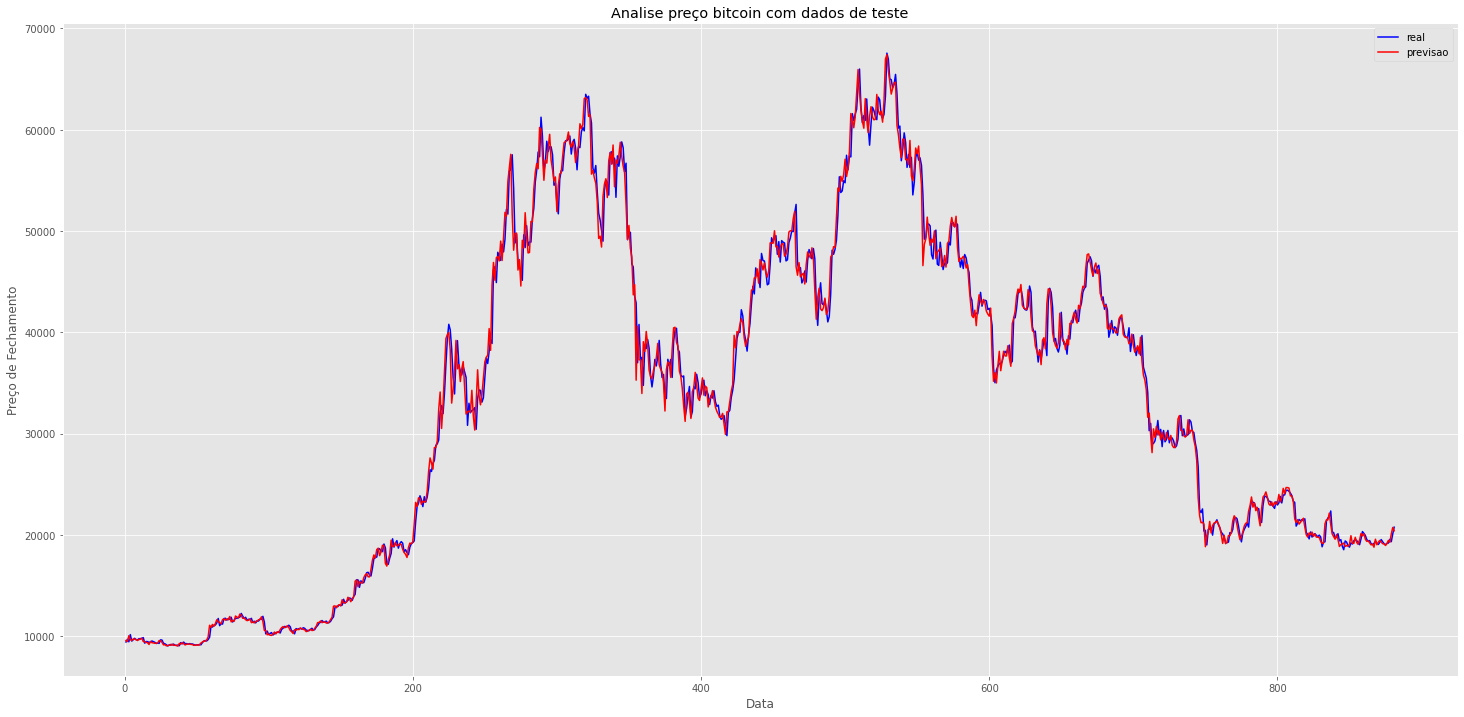

In [ ]:
plt.figure(figsize=(25,12))
plt.title("Analise preço bitcoin com dados de teste")
plt.plot(df["real"], label="real", color="blue")
plt.plot(df["previsao"], label="previsao", color="red")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
leg = plt.legend()

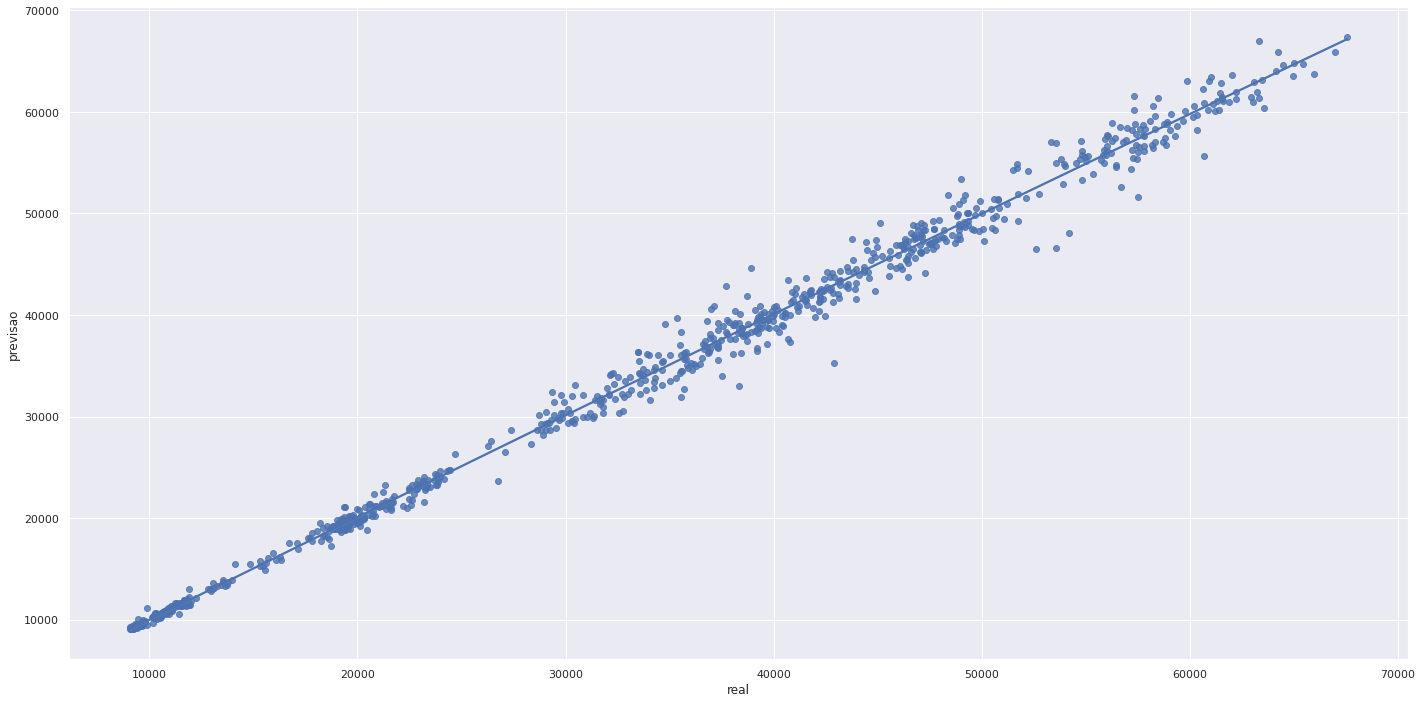

In [ ]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(24, 12)})
sns.regplot(x ="real", y ="previsao", data = df, ci=False, order=2)

- Export modelo preditivo 

In [ ]:
joblib.dump(pipeline_linear_regression, 'model_btc_usd.pkl')

['model_btc_usd.pkl']

- Import modelo preditivo

In [ ]:
model = joblib.load('model_btc_usd.pkl')